# TestCommands
Using something like that:
```shell
sudo ping -O -D -t 25 -v 8.8.8.8 -i 0.05 > pingtest-5G-50msDelay-googledns
sudo ping -O -D -t 25 -v 8.8.8.8 -i 1 > pingtest-5G-1sDelay-googledns

# not working yet and unclear
sudo hping3 mealie.horotw.com --destport 80 --numeric --ack --interval u50000 | xargs -I {} bash -c 'echo "[$EPOCHREALTIME] {}"' > pingtest-50msdelay-hping-mealie.yggdrasil-ack
```

In [38]:
# Set the number of images to analyze
if "ANALYZE_COUNT" in locals():
    print("ANALYZE_COUNT is defined")
else:
    print("ANALYZE_COUNT is not defined falling back to 12")
    ANALYZE_COUNT = 12

if "COUNT_AS_LOSS_IF_OVER" in locals():
    print("COUNT_AS_LOSS_IF_OVER is defined")
else:
    print("COUNT_AS_LOSS_IF_OVER is not defined falling back to using 5x std deviation")
    COUNT_AS_LOSS_IF_OVER = -1

ANALYZE_COUNT is defined
COUNT_AS_LOSS_IF_OVER is defined


In [39]:
from tabulate import tabulate
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML
from parsefuncs import parse_ping_file, parse_hping_file

In [40]:
data_files = glob.glob("pingtest-*")

dfs = []
def read_dfs():
    global dfs, data_files
    dfs = []

    # sort the files by creation time and take the last ANALYZE_COUNT files
    data_files.sort(key=os.path.getctime, reverse=True)
    data_files = data_files[:ANALYZE_COUNT]


    # Read the data using a regular expression to extract the relevant fields
    for data_file in data_files:
        if "hping" in data_file:
            data = parse_hping_file(data_file)
            dfs.append(data)
        else:  # normal ping
            data = parse_ping_file(data_file, COUNT_AS_LOSS_IF_OVER)
            dfs.append(data)

read_dfs()
print(f"Number of dataframes: {len(dfs)}")
print(f"Number of data_files: {len(data_files)}")

Number of NaN lines: 1
Number of lines with no answer: 1
Number of NaN lines: 0
Number of lines with no answer: 0
Number of dataframes: 2
Number of data_files: 2


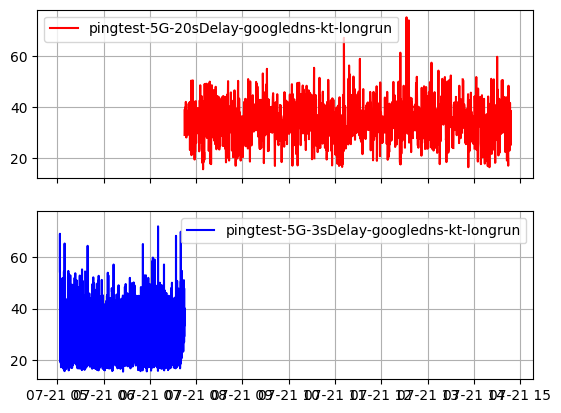

In [41]:
# create subplots
fig, axs = plt.subplots(len(dfs), 1, sharex=True, sharey=True)
axs = np.atleast_1d(axs)  # Ensure axs is treated as an array-like object
colors =[ "red", "blue", "green", "orange", "black", "yellow", "pink", "purple", "brown", "gray", "cyan", "magenta"]

for i, df in enumerate(dfs):
    color = colors[i]
    axs[i].plot(df["timestamp"], df["time"], label=data_files[i], color=color)
    axs[i].legend()
    axs[i].grid()

plt.show()

In [42]:
statistics = []

def get_statistics():
    global statistics, data_files, dfs
    print(f"Number of dataframes: {len(dfs)}")
    print(f"Number of data_files: {len(data_files)}")

    for i, df in enumerate(dfs):
        loss_count = len(df[df.isna().any(axis=1)])
        stats = {
            "DataFrame": data_files[i],
            "Mean": df["time"].mean(),
            "Median": df["time"].median(),
            "Std Dev": df["time"].std(),
            "Min": df["time"].min(),
            "Max": df["time"].max(),
            "q25": df["time"].quantile(0.25),
            # "q50": df["time"].quantile(0.5),  # same as median
            "q75": df["time"].quantile(0.75),
            "q90": df["time"].quantile(0.9),
            "q95": df["time"].quantile(0.95),
            "q99": df["time"].quantile(0.99),
            "Loss Rate in %": (loss_count / len(df)) * 100,
            "|loss|": loss_count,
        }
        statistics.append(stats)
    return statistics

statistics = get_statistics()

Number of dataframes: 2
Number of data_files: 2


In [46]:
# Create a subplot with a single trace per dataframe
# Also with a slightly larger heigt
fig = make_subplots(rows=2, cols=1)

# Create a plot with time on the x-axis and value on the y-axis
for i, df in enumerate(dfs):
    trace = go.Scatter(
        x=df["timestamp"],
        y=df["time"],
        mode="lines+markers",
        name=data_files[i],
        showlegend=True,
        line=dict(color=colors[i], width=1),
    )
    fig.add_trace(trace, row=1, col=1)

# where time is NaN insert a vertical red line
for i, df in enumerate(dfs):  # for each dataframe
    for index, row in df.iterrows():  # for each row
        # to check for NaN use np.isnan(row["time"])
        if np.isnan(row["time"]):
            fig.add_shape(
                # Line Vertical
                dict(
                    type="line",
                    x0=row["timestamp"],
                    y0=0,
                    x1=row["timestamp"],
                    y1=100,
                    line=dict(color=colors[i], width=3)
                )
            )
            fig.add_annotation(
                x=row["timestamp"],
                y=100,
                text="Miss",
                showarrow=True,
                arrowhead=1,
                ax=0,
                ay=-40,
                font=dict(color="red", size=16),
            )

# Update the layout to make it more interactive
fig.update_layout(
    title="Scrub Through Time",
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="minute", stepmode="backward"),
                    dict(count=5, label="5m", step="minute", stepmode="backward"),
                    dict(count=30, label="30m", step="minute", stepmode="backward"),
                    dict(count=1, label="1h", step="hour", stepmode="backward"),
                    dict(count=3, label="3h", step="hour", stepmode="backward"),
                    dict(count=6, label="6h", step="hour", stepmode="backward"),
                    dict(count=12, label="12h", step="hour", stepmode="backward"),
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    ),
)

def pre_reload_func(*args):
    read_dfs()
    get_statistics()

f2 = go.FigureWidget(fig)
f2.layout.on_change(pre_reload_func, "title")
# Show the interactive plot
f2

# # for auto reloading:
# %load_ext autoreload
# %autoreload 2


FigureWidget({
    'data': [{'line': {'color': 'red', 'width': 1},
              'mode': 'lines+markers',
              'name': 'pingtest-5G-20sDelay-googledns-kt-longrun',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'e6bba8ae-4899-43cf-a437-7d7cae1984c8',
              'x': array([datetime.datetime(2023, 7, 21, 7, 44, 58, 32331),
                          datetime.datetime(2023, 7, 21, 7, 45, 18, 62398),
                          datetime.datetime(2023, 7, 21, 7, 45, 38, 72493), ...,
                          datetime.datetime(2023, 7, 21, 14, 47, 0, 727421),
                          datetime.datetime(2023, 7, 21, 14, 47, 20, 727664),
                          datetime.datetime(2023, 7, 21, 14, 47, 40, 757618)], dtype=object),
              'xaxis': 'x',
              'y': array([29.1, 39.1, 30.7, ..., 31.5, 25.1, 38.4]),
              'yaxis': 'y'},
             {'line': {'color': 'blue', 'width': 1},
              'mode': 'lines+markers',

Number of NaN lines: 1
Number of lines with no answer: 1
Number of NaN lines: 0
Number of lines with no answer: 0
Number of dataframes: 2
Number of data_files: 2


In [53]:
# data has changed, update the plot
f2.notify_change(change="figure")

TypeError: string indices must be integers, not 'str'

In [47]:
pre_reload_func()

Number of NaN lines: 1
Number of lines with no answer: 1
Number of NaN lines: 0
Number of lines with no answer: 0
Number of dataframes: 2
Number of data_files: 2


In [44]:
print(f"ANALYZE_COUNT: {ANALYZE_COUNT}")
table = tabulate(statistics, headers="keys", tablefmt="html") # possible tablefmt: plain, simple, grid, fancy_grid, github, jira, html, rst, mediawiki, latex, latex_raw, latex_booktabs, textile
display(HTML(table))

ANALYZE_COUNT: 2


DataFrame,Mean,Median,Std Dev,Min,Max,q25,q75,q90,q95,q99,Loss Rate in %,|loss|
pingtest-5G-20sDelay-googledns-kt-longrun,34.4984,34.3,8.28973,15.7,75,28.8,40.6,44.1,48.085,52.585,1.89274,24
pingtest-5G-3sDelay-googledns-kt-longrun,30.7982,29.9,8.64645,15.4,72.1,24.25,37.7,41.9,44.2,52,2.07688,67


In [45]:
#   7.6 + 0.18 = 7.78
#   7.6 + 1.44 = 9.04
ANALYZE_COUNT = 2
COUNT_AS_LOSS_IF_OVER = 75